# Network Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## Create user user_id list from the data

In [2]:
data = pd.read_csv('../output/preprocessed.csv')

user_dict = {}

# Function to add a user ID to a username
def add_user_id(username, user_id):
    if username in user_dict:
        user_dict[username].append(user_id)
    else:
        user_dict[username] = [user_id]

for index, row in data.iterrows():
    add_user_id(row['user'], row['user_id'])

{k: user_dict[k] for k in list(user_dict)[:5]}

{'danielwoodard': [1077866112],
 'nelsonjacqueline': [1089670430],
 'ihooper': [1007478642, 1007478642],
 'wrightnicholas': [1039258480],
 'michael51': [1021455936, 1096712805, 1022492390]}

In [3]:
data.head()

timestamp                                               text     text_id  \
0  00:00:00  run business mean juggle countless administrat...  2018569761   
1  00:00:00  liz truss walk linger shadow predecessor charl...  2092717718   
2  00:00:00  uk brace war government building london raise ...  2059143248   
3  00:00:00  marry second cousin remove taboo think genetic...  2008209828   
4  00:00:00  truly disgraceful indian national congress sto...  2001239278   

               user     user_id                                hashtags  \
0     danielwoodard  1077866112      ['#HRtech', '#businessmanagement']   
1  nelsonjacqueline  1089670430                           ['#politics']   
2           ihooper  1007478642  ['#Ukrainewashed', '#WarPreparedness']   
3    wrightnicholas  1039258480        ['#FamilyTree', '#GeneticFacts']   
4         michael51  1021455936                 ['#RationChorCongress']   

  mentions  frequency language  
0       []          1       en  
1       []          1       en  
2       []          1       en  
3       []          1       en  
4       []          1       en

In [4]:
# Create a new dataframe with non-empty mentions
data_mentions = data[data['mentions'].apply(lambda x: len(eval(x)) > 0)][['user', 'mentions']]
print(f"Number of posts with mentions: {len(data_mentions)}")
data_mentions.head()

Number of posts with mentions: 35322


user                                           mentions
5      ihooper  ['gabrieltaylor', 'lori57', 'timothy62', 'andr...
7       mark89  ['mckenzieestrada', 'mckenzieestrada', 'shane2...
8     andrea21                               ['jonathanreynolds']
10  kimberly05                                 ['bethanycarroll']
11   kristen10                                         ['wdavis']

In [5]:
graph_data = pd.read_csv('../data/graph.csv')

# Flatten the list of user IDs from user_dict
user_ids = set([user_id for user_ids in user_dict.values() for user_id in user_ids])

# Check if any user ID in the graph.csv is not in the user relation list
missing_users_set = set(graph_data['source']).union(set(graph_data['target'])) - user_ids

# Convert the set of missing users to a DataFrame
missing_users = pd.DataFrame(list(missing_users_set), columns=['user_id'])

print(f"Number of missing users: {len(missing_users)}")

Number of missing users: 717


These user id's from the graph_data cannot be resolved, because there are not in the dataset

In [6]:
missing_users.head()

user_id
0  1005090817
1  1046982657
2  8181721092
3  1048807428
4  1192646665

In [7]:
# Filter out rows where source or target is in missing_users_set, because we do not have the data

initial_row_count = len(graph_data)
graph_data = graph_data[~graph_data['source'].isin(missing_users_set) & ~graph_data['target'].isin(missing_users_set)]
filtered_row_count = len(graph_data)

print(f"Number of removed rows: {initial_row_count - filtered_row_count}")

Number of removed rows: 2880


In [8]:
# Transform the user_ids in graph_data to usernames according to the dictionairy

graph_data['source'] = graph_data['source'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data['target'] = graph_data['target'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data.head()

source         target  weight
0  eleonard     jamessimon       1
1  eleonard      brianna65       1
2  eleonard       yschmidt       1
5  eleonard       amanda97       1
6  eleonard  rosariohannah       1

In [9]:
len(graph_data)

92004

In [10]:
non_empty_mentions_count = data[data['mentions'].apply(lambda x: len(eval(x)) > 0)].shape[0]
print(f"Number of rows in data with non-empty mentions: {non_empty_mentions_count}")

Number of rows in data with non-empty mentions: 35322


### Mentions (directed)

In [11]:
# Create a directed graph
mentioning_graph = nx.DiGraph()

# Add edges to the graph based on mentions
for index, row in data_mentions.iterrows():
    user = row['user']
    mentions = eval(row['mentions'])
    for mentioned_user in mentions:
        mentioning_graph.add_edge(user, mentioned_user)

# Print the number of nodes and edges in the mentioning graph
print(f"Number of nodes in the mentioning graph: {mentioning_graph.number_of_nodes()}")
print(f"Number of edges in the mentioning graph: {mentioning_graph.number_of_edges()}")

Number of nodes in the mentioning graph: 53183
Number of edges in the mentioning graph: 88159


In [12]:
# Compute in-degree centrality for the mentioning graph (directed)
in_degree_centrality_mentions = nx.in_degree_centrality(mentioning_graph)

### Followers (undirected)

In [13]:
# Create an undirected graph
following_graph = nx.Graph()

# Add edges to the graph
for index, row in graph_data.iterrows():
        following_graph.add_edge(row['source'], row['target'], weight=row['weight'])

# Print the number of nodes and edges in the graph
print(f"Number of nodes: {following_graph.number_of_nodes()}")
print(f"Number of edges: {following_graph.number_of_edges()}")

Number of nodes: 37241
Number of edges: 91969


In [14]:
# Compute degree centrality for the following graph (undirected)
degree_centrality_following = nx.degree_centrality(following_graph)

In [15]:
# Get the top 10 users by degree centrality
top_10_degree_centrality = sorted(degree_centrality_following.items(), key=lambda x: x[1], reverse=True)[:10]

# Calculate the number of followers for each user in top_10_degree_centrality
total_nodes = following_graph.number_of_nodes()
followers_count = [(user, int(followers * (total_nodes - 1))) for user, followers in top_10_degree_centrality]

# Print the number of followers for each user
print("Number of followers for the top 10 users:")
for user, count in followers_count:
    print(f"{user}: {count}")

Number of followers for the top 10 users:
robert78: 1744
zsmith: 96
chaddiaz: 90
rharris: 86
tclark: 84
wsmith: 80
melinda91: 75
timothy45: 73
ismith: 69
imorgan: 68


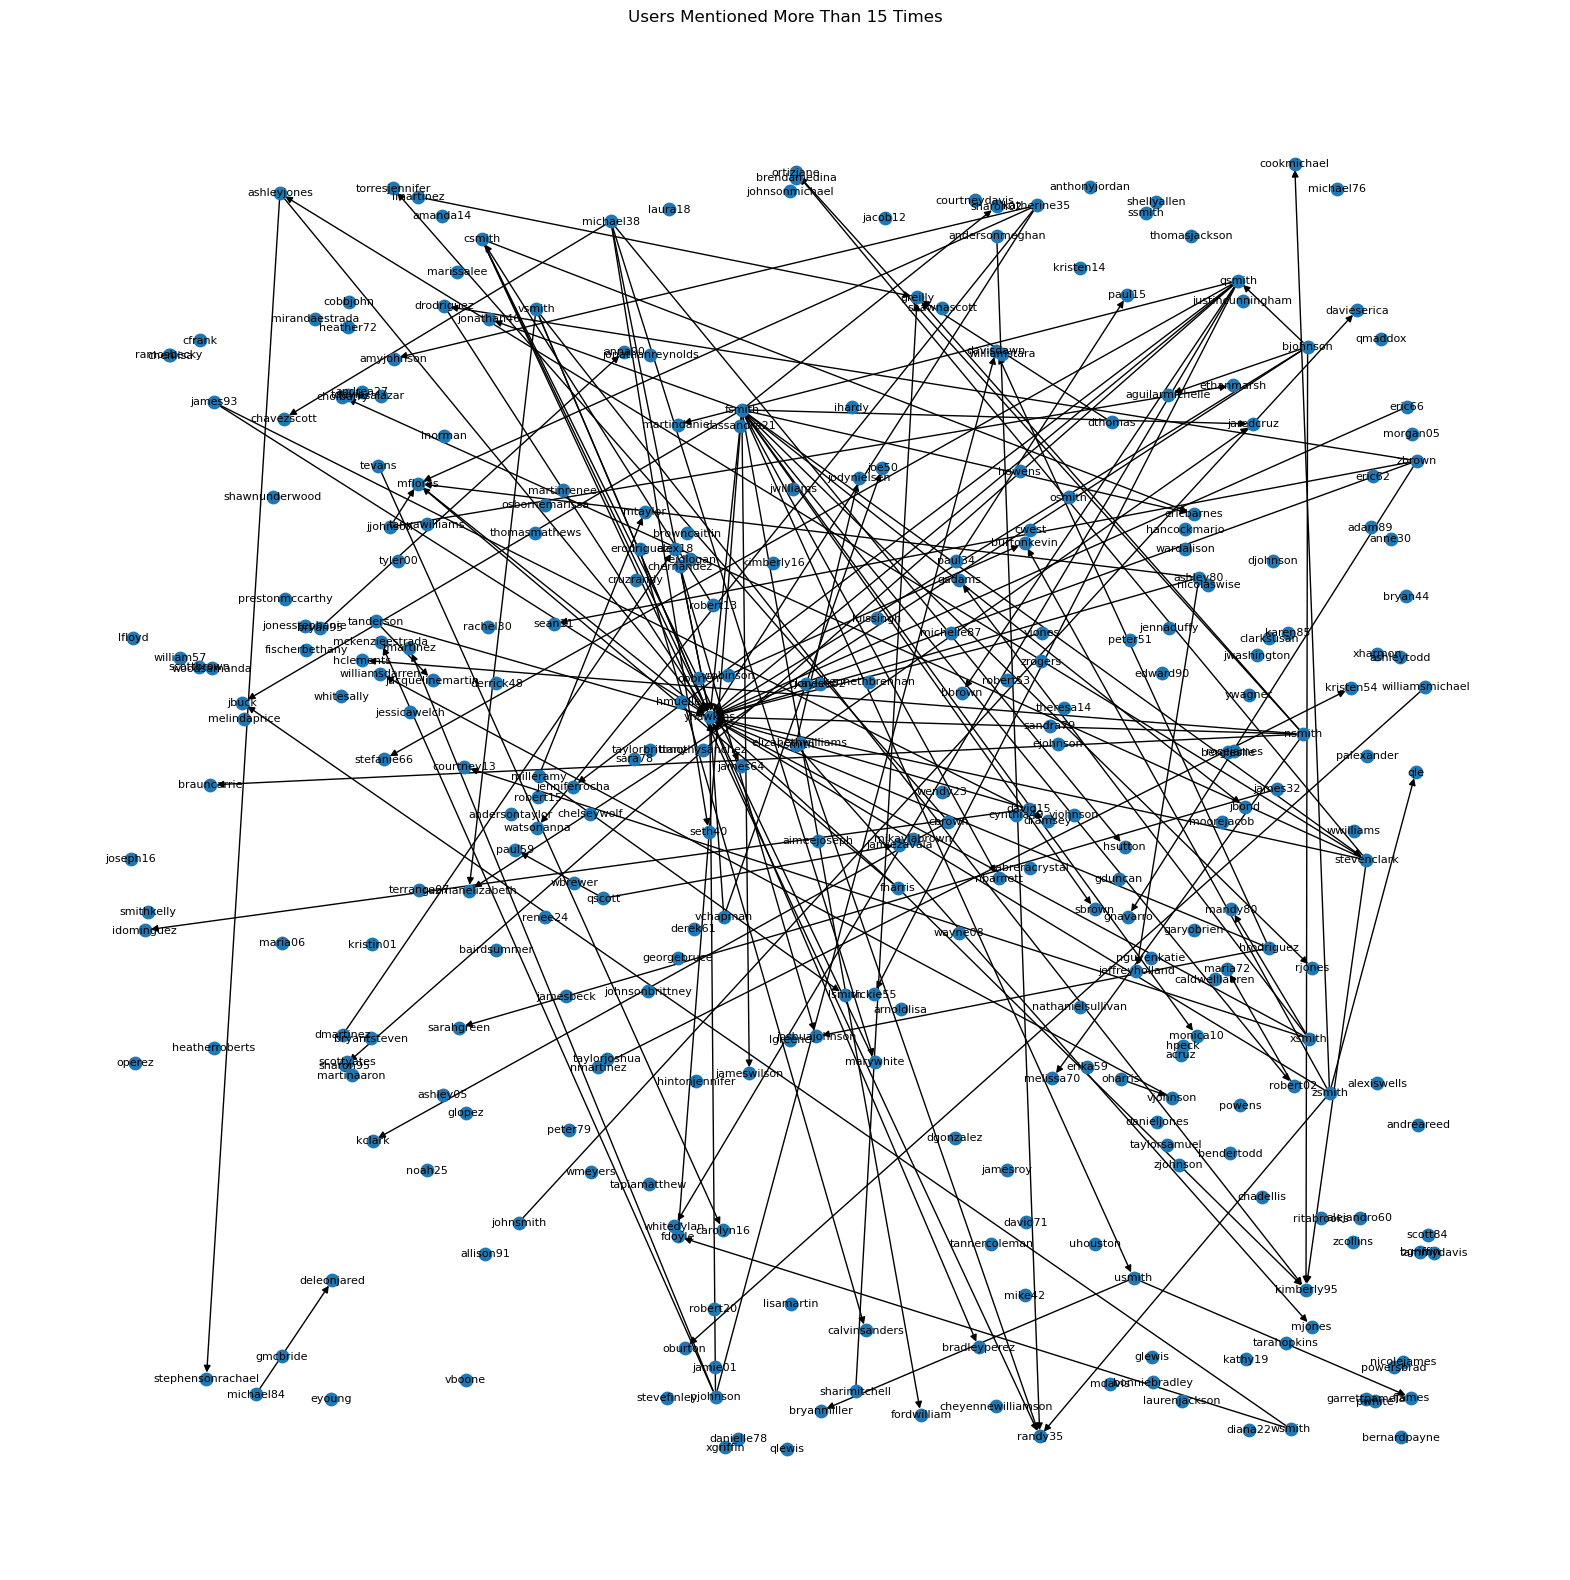

In [16]:
# Filter nodes with in-degree greater than 15
nodes_to_visualize = [node for node, in_degree in mentioning_graph.in_degree() if in_degree > 15]

# Create a subgraph with the filtered nodes
subgraph = mentioning_graph.subgraph(nodes_to_visualize)

# Generate positions for the nodes
pos = nx.random_layout(subgraph)

# Draw the subgraph
plt.figure(figsize=(20, 20))
nx.draw_networkx(subgraph, pos, node_size=80, font_size=8, with_labels=True, font_color='black')
plt.title("Users Mentioned More Than 15 Times")
plt.axis("off")
plt.show()

### Ego networks

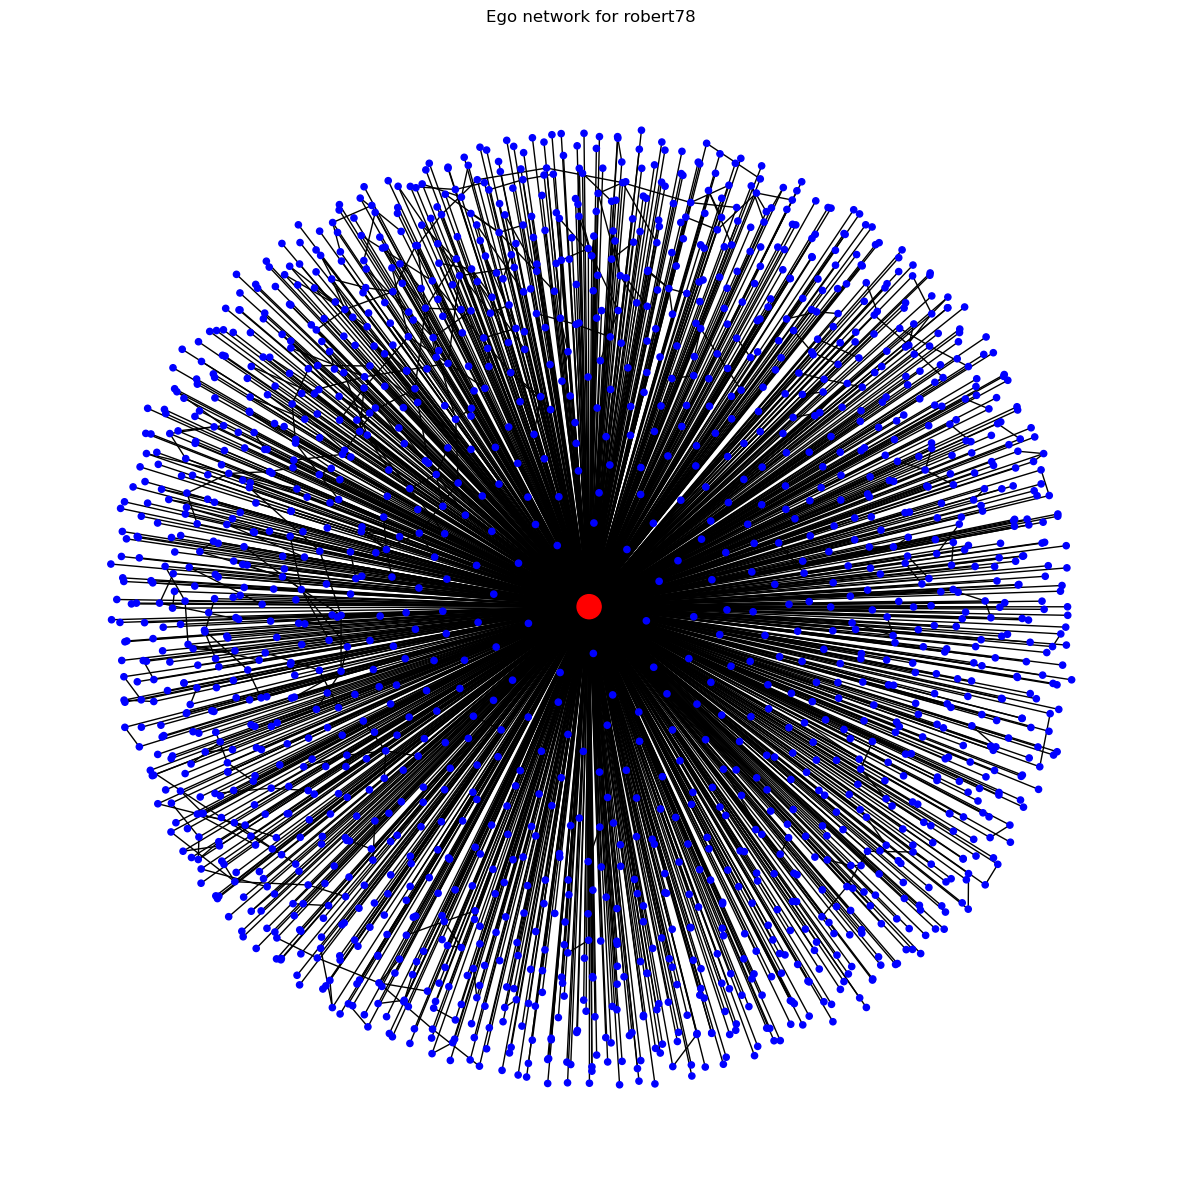

In [18]:
# Create an ego network for robert78
ego_network_robert78 = nx.ego_graph(following_graph, 'robert78')

# Draw the ego network with a larger figure size
layout = nx.spring_layout(ego_network_robert78)
plt.figure(figsize=(15, 15))

# Draw nodes with specific attributes for 'robert78'
node_colors = ['red' if node == 'robert78' else 'blue' for node in ego_network_robert78.nodes()]
node_sizes = [300 if node == 'robert78' else 20 for node in ego_network_robert78.nodes()]

nx.draw_networkx(ego_network_robert78, pos=layout, node_color=node_colors, node_size=node_sizes, font_size=8, with_labels=False)
plt.title("Ego network for robert78")
plt.axis("off")
plt.show()

In [19]:
ego_network_robert78.number_of_nodes()

1745

## Playground

### Louvain

In [20]:
# Apply Louvain to the undirected following_graph
partition_following = nx.algorithms.community.louvain_communities(following_graph)

# Convert mentioning_graph to undirected for Louvain
mention_graph_undirected = mentioning_graph.to_undirected()
partition_mention = nx.algorithms.community.louvain_communities(mention_graph_undirected)

# Convert the partition lists to dictionaries for easier lookup
node_to_community_following = {}
for i, community in enumerate(partition_following):
	for node in community:
		node_to_community_following[node] = i

node_to_community_mention = {}
for i, community in enumerate(partition_mention):
	for node in community:
		node_to_community_mention[node] = i

In [31]:
from collections import Counter

# Count the number of members in each community
counts = Counter({i: len(community) for i, community in enumerate(partition_following)})
sorted_communities = counts.most_common()

# Print the top communities
for comm_id, size in sorted_communities[:15]:
    print(f"Community {comm_id} has {size} members")

Community 23 has 740 members
Community 39 has 627 members
Community 73 has 621 members
Community 77 has 621 members
Community 57 has 613 members
Community 40 has 611 members
Community 46 has 568 members
Community 9 has 552 members
Community 85 has 549 members
Community 55 has 545 members
Community 56 has 545 members
Community 27 has 542 members
Community 80 has 541 members
Community 15 has 540 members
Community 68 has 538 members


In [22]:
# Simple comparison of how many nodes share the same community
shared_nodes = set(node_to_community_following.keys()).intersection(node_to_community_mention.keys())
same_community_count = sum(
	1 for node in shared_nodes 
	if node_to_community_following[node] == node_to_community_mention[node]
)

print(f"Number of communities in following: {len(partition_following)}")
print(f"Number of communities in mention: {len(partition_mention)}")
print(f"Number of nodes in the same community across both graphs: {same_community_count}")
print(f"Total shared nodes: {len(shared_nodes)}")

Number of communities in following: 91
Number of communities in mention: 2063
Number of nodes in the same community across both graphs: 64
Total shared nodes: 25530


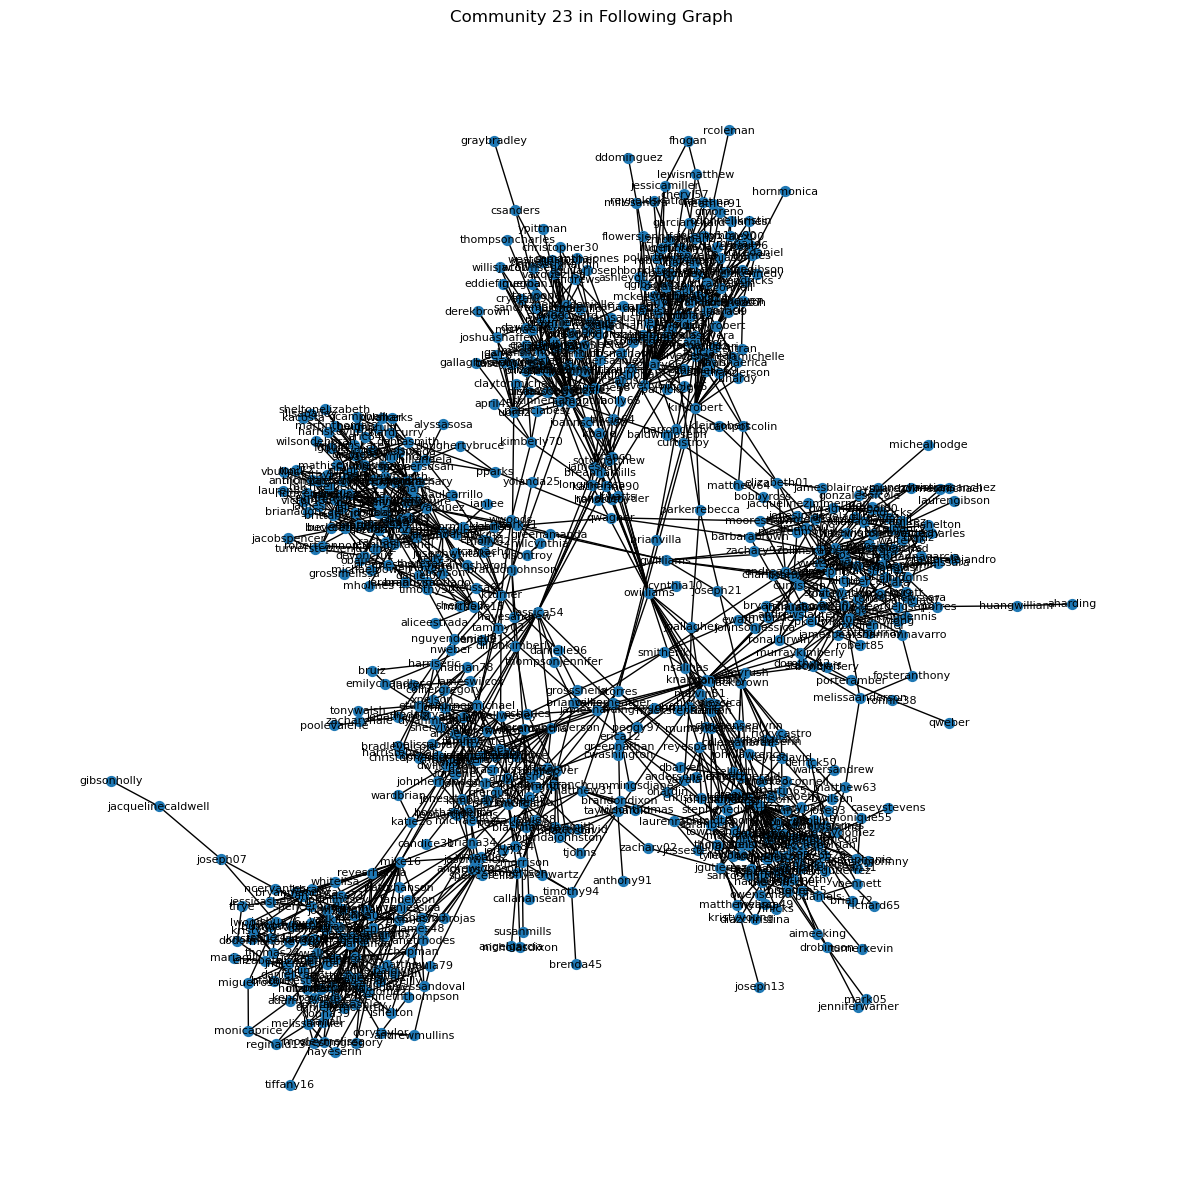

In [40]:
# Extract nodes in Community 47
community_47_nodes = partition_following[23]

# Create a subgraph for Community 23
community_23_subgraph = following_graph.subgraph(community_47_nodes)

# Draw the subgraph with a larger figure size
plt.figure(figsize=(15, 15))
pos = nx.fruchterman_reingold_layout(community_23_subgraph)
nx.draw_networkx(community_23_subgraph, pos, node_size=50, font_size=8, with_labels=True)
plt.title("Community 23 in Following Graph")
plt.axis("off")
plt.show()

In [24]:
# Create a dictionary to store the top users with the most followers in each community
top_users_by_community = {}

# Iterate over each community in partition_following
for community_index, community in enumerate(partition_following):
    # Filter the in-degree dictionary to include only nodes in the current community
    community_in_degree = {node: degree_centrality_following[node] for node in community if node in degree_centrality_following}
    
    # Find the user with the most followers in the current community
    if community_in_degree:
        top_user = max(community_in_degree, key=community_in_degree.get)
        top_users_by_community[community_index] = (top_user, community_in_degree[top_user])

# Print the top users with the most followers in each community
for community_index, (user, followers) in top_users_by_community.items():
    print(f"Community {community_index}: {user} with {followers} followers")

Community 0: allen16 with 0.001288936627282492 followers
Community 1: howardnichole with 0.0010472610096670246 followers
Community 2: wroberts with 0.0010472610096670246 followers
Community 3: mosleylori with 0.0007787325456498389 followers
Community 4: vmiller with 0.0011815252416756176 followers
Community 5: michael59 with 0.0016917293233082707 followers
Community 6: erodriguez with 0.0011278195488721805 followers
Community 7: pgonzalez with 0.001476906552094522 followers
Community 8: ysilva with 0.001611170784103115 followers
Community 9: scottdaniels with 0.0012083780880773362 followers
Community 10: dustinbrown with 0.0009935553168635876 followers
Community 11: rharris with 0.0023093447905477983 followers
Community 12: david35 with 0.0008861439312567133 followers
Community 13: tlivingston with 0.0006713211600429646 followers
Community 14: qthomas with 0.000832438238453276 followers
Community 15: michaelwilson with 0.0012352309344790548 followers
Community 16: uhunt with 0.00104726

/tmp/ipykernel_23853/3451438963.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(partition_following))


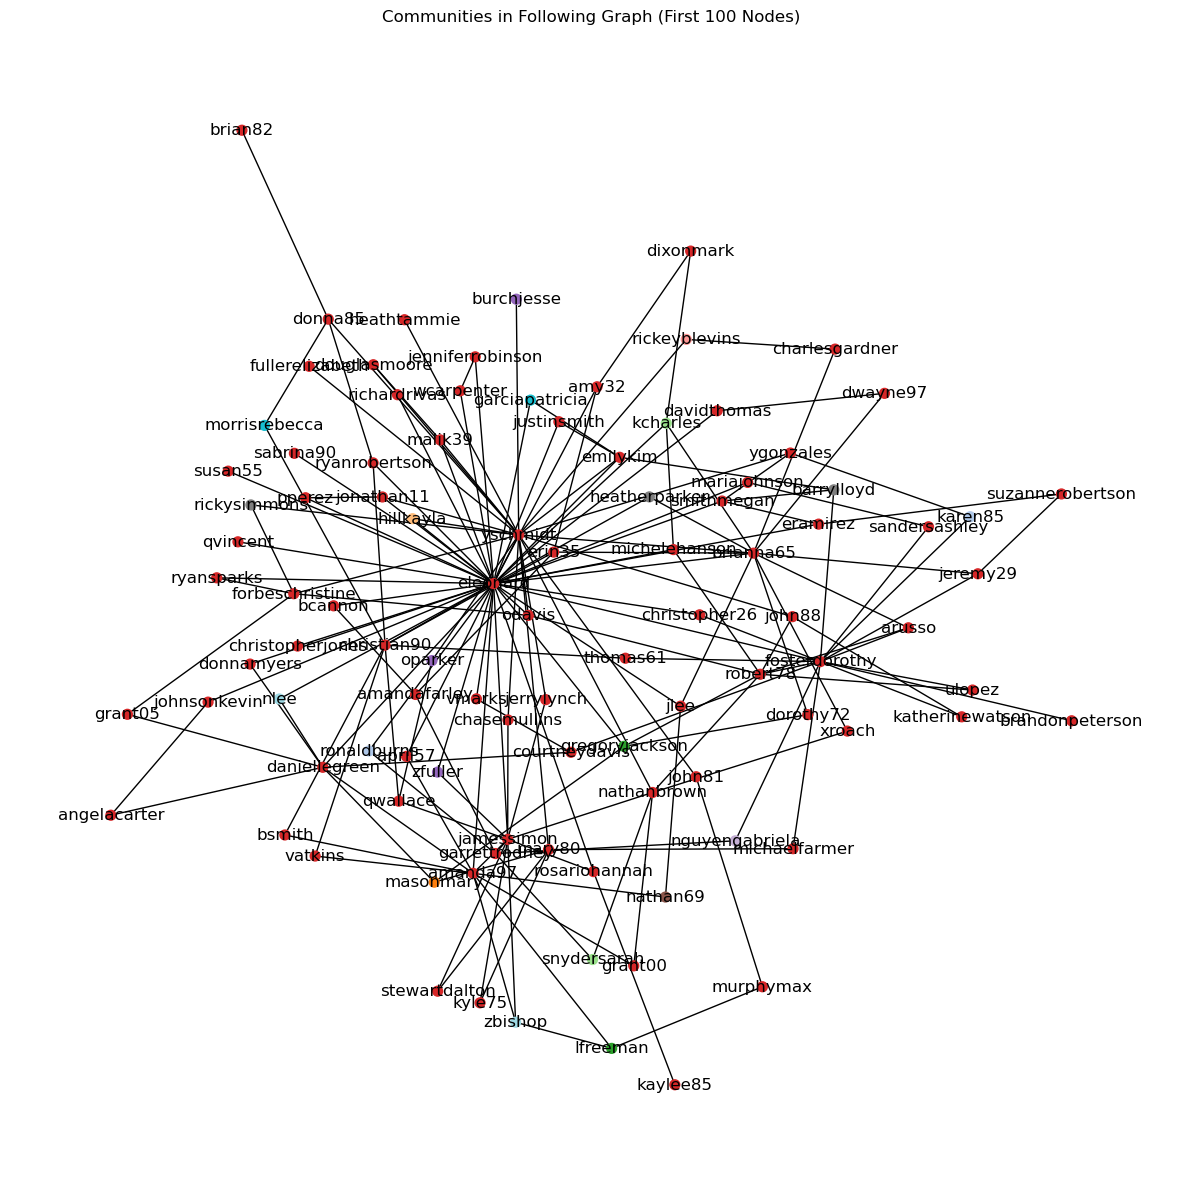

In [26]:
# Create a color map for the communities
color_map = plt.cm.get_cmap('tab20', len(partition_following))

# Create a dictionary to map each node to its community color
node_color_map = {}
for community_index, community in enumerate(partition_following):
    for node in community:
        node_color_map[node] = color_map(community_index)

# Take the first 100 nodes
nodes_to_visualize = list(following_graph.nodes())[:100]

# Generate positions for the nodes
pos = nx.spring_layout(following_graph.subgraph(nodes_to_visualize))

# Draw the graph with community colors
plt.figure(figsize=(15, 15))
nx.draw_networkx(following_graph.subgraph(nodes_to_visualize), pos, node_color=[node_color_map[node] for node in nodes_to_visualize], node_size=50, with_labels=True)
plt.title("Communities in Following Graph (First 100 Nodes)")
plt.axis("off")
plt.show()

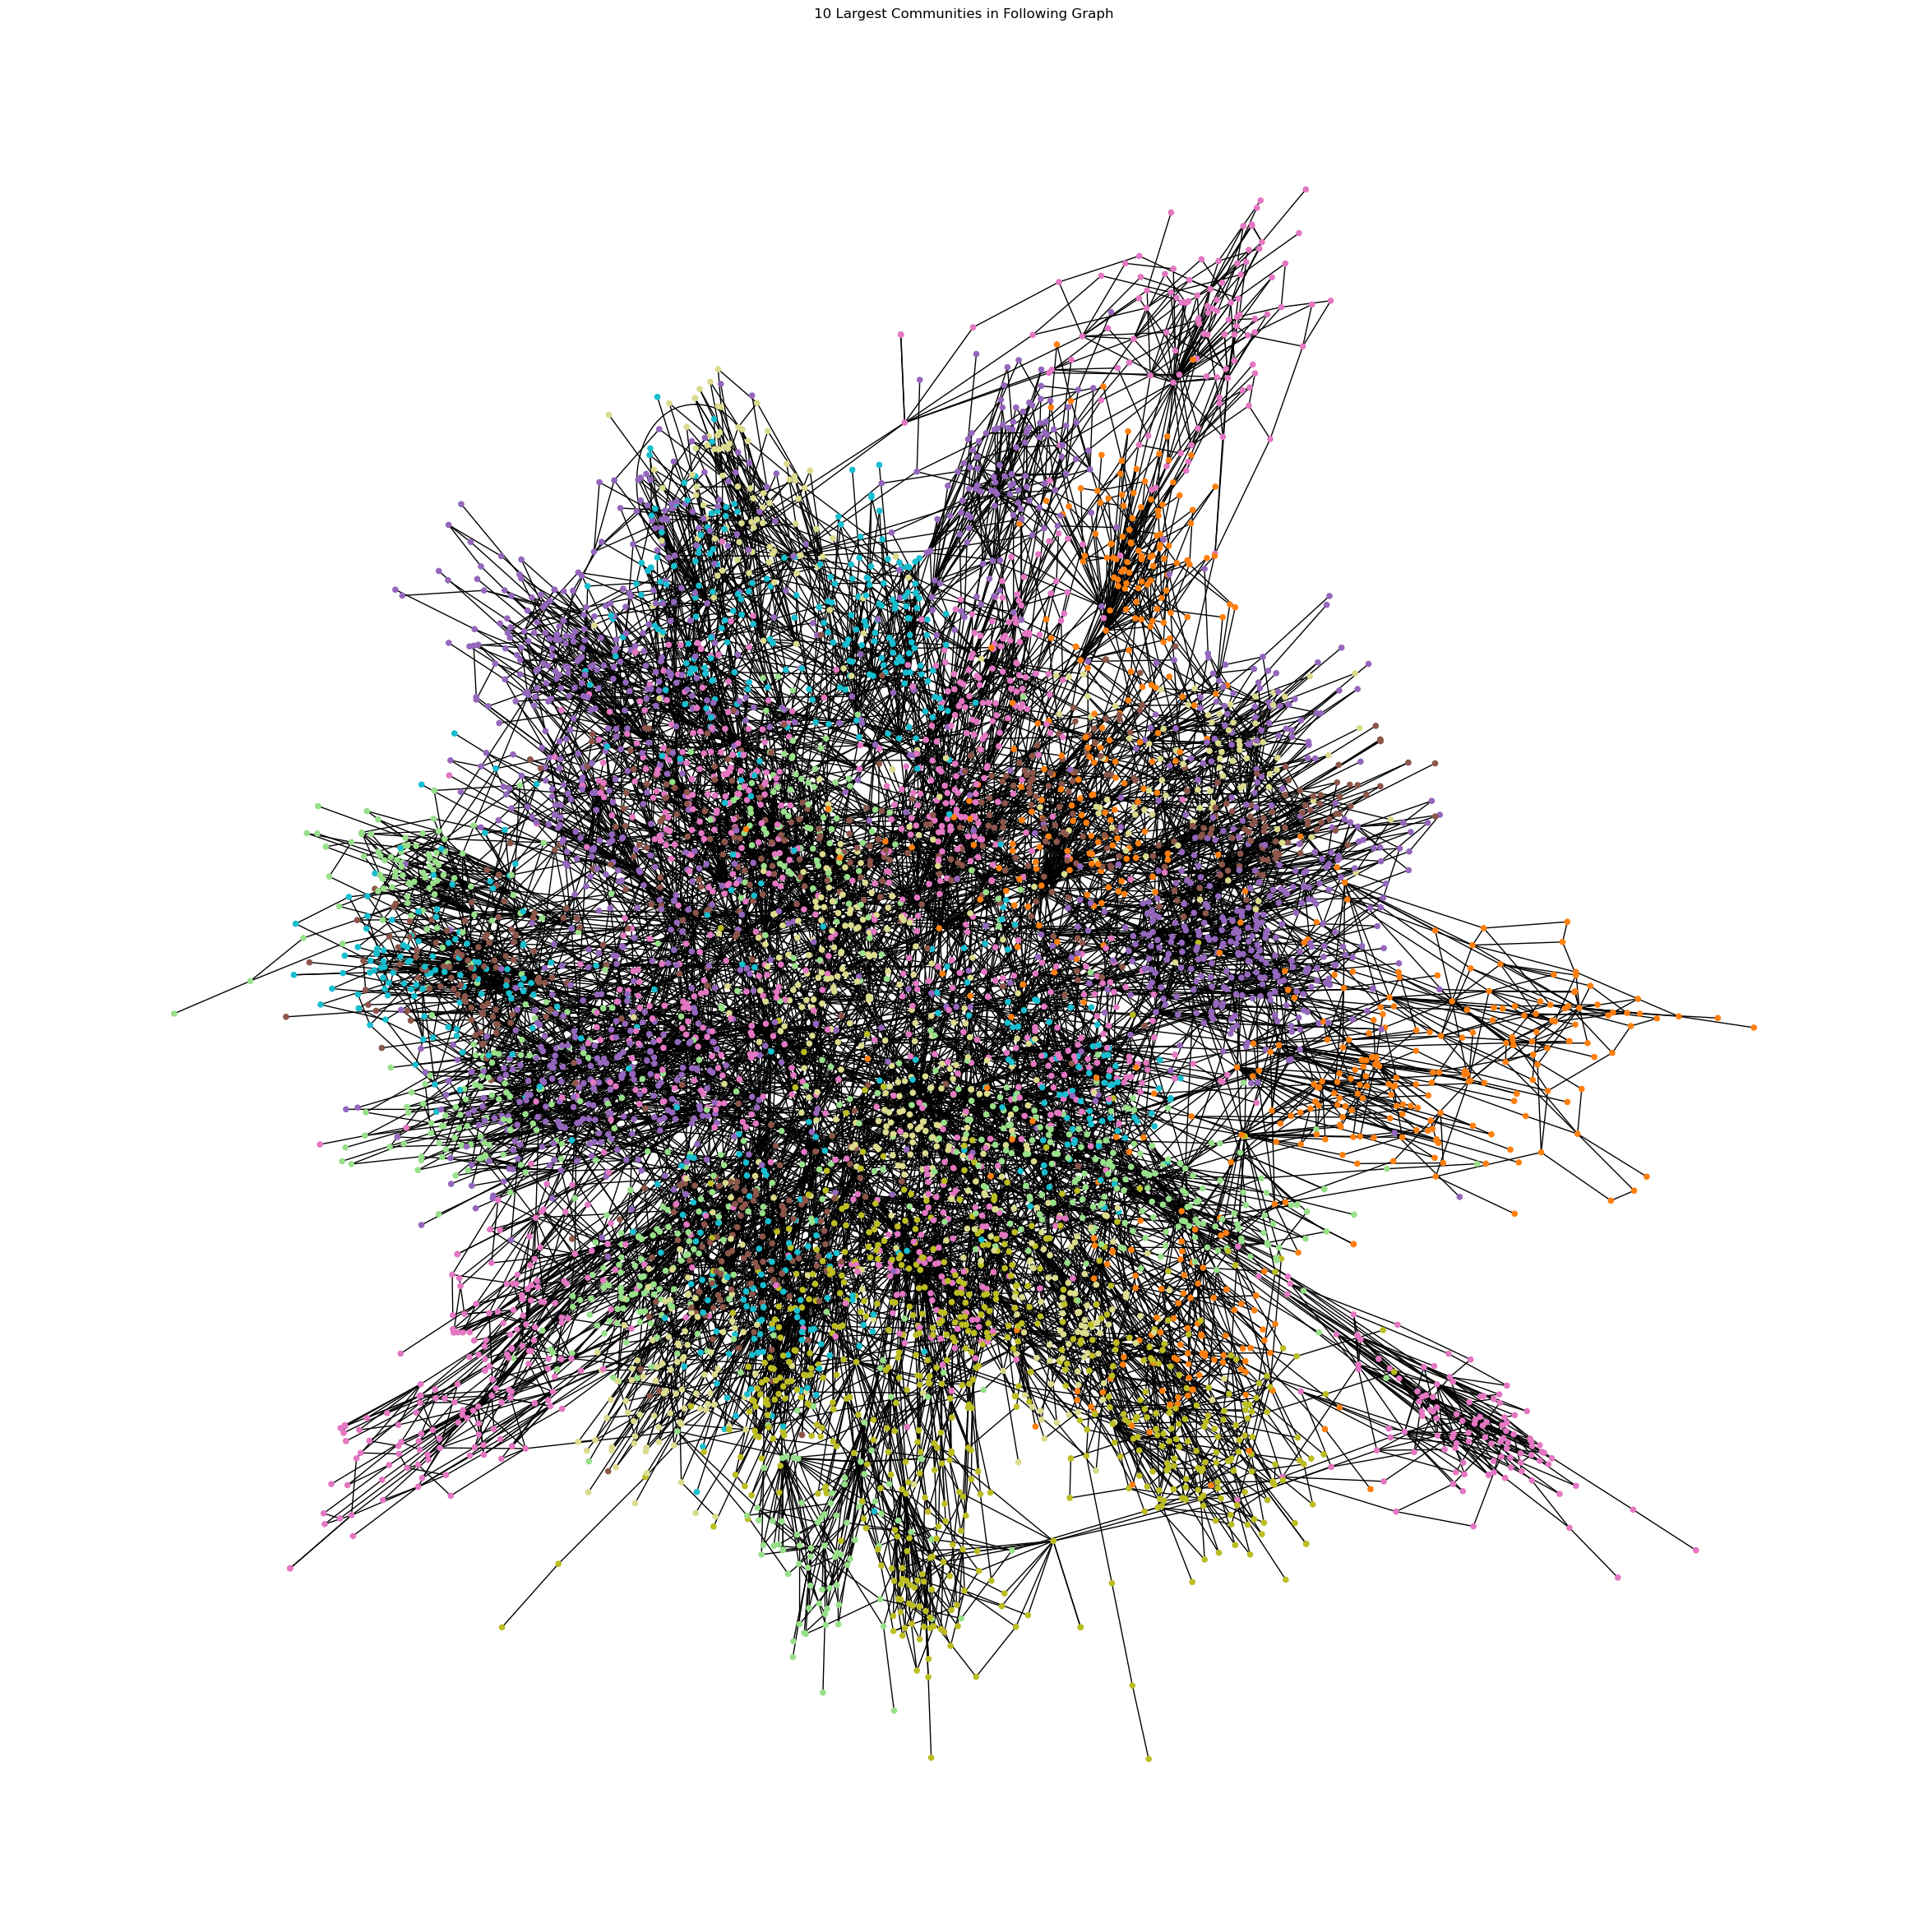

In [51]:
# Identify the 10 largest communities
largest_communities = [comm_id for comm_id, size in sorted_communities[:10]]

# Gather all nodes in these communities
largest_nodes = set()
for c_id in largest_communities:
    largest_nodes.update(partition_following[c_id])

# Create a subgraph for the 10 largest communities
largest_subgraph = following_graph.subgraph(largest_nodes)

# Generate positions and plot
plt.figure(figsize=(30, 30))
pos_largest = nx.spring_layout(largest_subgraph)
nx.draw_networkx(
    largest_subgraph,
    pos_largest,
    node_color=[node_color_map[n] for n in largest_subgraph.nodes()],
    node_size=20,
    with_labels=False
)
plt.title("10 Largest Communities in Following Graph")
plt.axis("off")
plt.show()